<a href="https://colab.research.google.com/github/art-glazunov/MegaFon_RecSys_Workshop/blob/main/Part_3_Baseline_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MegaFon RecSys workshop
by Artyom Glazunov

## Part 3. Baseline solution

## The plan

- ### Data loading
- ### Baseline and random rankers 
- ### Useful evaluation methods
- ### Models evaluation

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest_22/data

/content/drive/MyDrive/Colab_Notebooks/datafest_22/data


### Data loading

In [ ]:
data_train_pos = pd.read_csv("train_pos.csv")
data_train_all = pd.read_csv("train.csv")
data_val = pd.read_csv("validation.csv")
data_test = pd.read_csv("test.csv")
cold_users_data = pd.read_csv("cold_users_data.csv")
cold_items_data = pd.read_csv("cold_items_data.csv")

In [ ]:
data_train_pos.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,31,female,9,2011-04-19,2017-06-20
1,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,33,female,9,2008-08-05,2017-10-06
2,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,0,NaN,7,2011-02-25,2017-09-12
3,73q3/E5FIUwCSo9uPyhKcc1FNO9DqnaZqX7uDK5Rr7E=,XywiBSwrlFPkeg1pNJcH99AxP8loYVD8Twr+WrjjqxM=,discover,Online playlist more,online-playlist,1,199392.0,139|125|109,Al Green,Al Green,NaN,52.0,Let's Stay Together,US2HK0913701,1,0,NaN,7,2016-01-05,2017-10-05
4,M6fFPRO/pOaaWoergvHHsFzEUbW4YU6DKxqBDyYSbYU=,yiaUAbtf5E8J/aLzeDe3V/zT/sXzbZiIE3m/JvEB1jI=,search,Search,song,1,235416.0,444,Girls' Generation (少女時代),Cho Yun Kyoung| Kim Hee Jung| Harvey Mason Jr....,NaN,31.0,Mr.Mr.,KRA301300351,1,0,NaN,4,2016-12-13,2016-12-16


### Let's create a simple ranker based on the popularity of songs

In [ ]:
class PopularRanker(TransformerMixin, BaseEstimator):
    """Simple ranker based on value counts of 
    users positive responces 
    """

    def __init__(self, column_to_agg="song_id"):
        self.column_to_agg = column_to_agg #item id column

    def fit(self, data):
        """Compute counts

        data - training dataset with only POSITIVE responces
        """

        self.counts = data[self.column_to_agg].value_counts().to_dict()
        return self

    def get_score(self, data):
        """Map the counts to the given items ids

        data - test dataset
        """

        data_new = data.copy()
        data_new["score"] = data_new[self.column_to_agg].map(self.counts).fillna(-1).values
        return data_new

### For comparison purposes, we'll create a random ranker with constant predictions

In [ ]:
class RandomRanker(TransformerMixin, BaseEstimator):
    """Ranker that maps zeros as scores to emulate random algorithm
    !!! we need shuffled data !!!
    """

    def get_score(self, data):
        """Map zeros as scores to emulate random algorithm 

        data - test dataset
        """

        data_new = data.copy()
        data_new["score"] = [0] * data_new.shape[0]
        return data_new

### Initialize some useful methods

In [ ]:
def get_result_df(data_val, result_cols, scores):
    """Get resulting dataframe

    data_val - initial data with features
    result_cols - columns without scores (ids, other useful info)
    scores - predicted scores
    """
    
    real_pred_df = data_val[result_cols].copy()
    real_pred_df['score'] = scores
    return real_pred_df


def users_roc_auc_scores(real_pred_data, id_col="msno", 
                         target_col="target", score_col="score"):
    """Compute ROC AUC scores
    for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    roc_auc_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        roc_auc_scores.append(roc_auc_score(data_us[target_col], data_us[score_col]))
    return roc_auc_scores


def users_rr_scores(real_pred_data, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute RR scores for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    rr_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)\
                                .reset_index(drop=True)
        rr_score = 1 / ((data_us_sorted.target == 1).argmax() + 1)
        rr_scores.append(rr_score)
    return rr_scores


def precision_at_k(real_pred_data, k=5, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute precision@k scores for users

    real_pred_data - data with target and score
    k - size of the top 
    id_col- user_id column
    target_col, score_col - columns with target values and model's scores
    """

    precision_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)
        precision_score = data_us_sorted.iloc[:k].target.sum() / k
        precision_scores.append(precision_score)
    return precision_scores


def test_data_preprocessing(data_test, id="msno", k=10, 
                            min_prop=0.05, max_prop=0.95):
    """Pick only users 
    with both positive and negative responces

    data_test - data to transform
    id - user id column name
    k - minimum number of songs that a user interacted with
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """

    data_new = data_test.copy()
    val_users = []
    for user_id, data_us in data_new.groupby([id]):
        pos_cnt = data_us.target.sum()
        cnt = data_us.shape[0]
        pos_prop = pos_cnt / cnt
        if cnt >= k and pos_prop > min_prop and pos_prop < max_prop:
            val_users.append(user_id)    

    data_prep = data_new[data_new[id].isin(val_users)].reset_index(drop=True)
    return data_prep


def model_evaluation(model, data_val, result_cols, user_id, n, k=5, 
                     min_prop=0.05, max_prop=0.95):
    """Baseline models evaluation function

    model - PopularRanker model
    data_val - validation dataframe
    result_cols - columns form initial dataset to consider in final
    user_id - user id column name
    n - minimum number of songs that a user interacted with
    k - size of the top 
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """

    data_val_prep = test_data_preprocessing(data_val[result_cols], id=user_id, k=n,
                                            min_prop=min_prop, max_prop=max_prop)
    val_real_pred = model.get_score(data_val_prep)
    roc_auc_scores = users_roc_auc_scores(val_real_pred)
    rr_scores = users_rr_scores(val_real_pred)
    p_at_k_scores = precision_at_k(val_real_pred, k=k)
    print(f"Users mean AUC ROC on test: {np.mean(roc_auc_scores)}")
    print(f"Users mean reciprocal rank on test: {np.mean(rr_scores)}")
    print(f"Users mean precision@{k} on test: {np.mean(p_at_k_scores)}")
    plt.figure()
    plt.hist(roc_auc_scores)
    plt.title("USERS AUC ROC SCORES")
    plt.grid()
    plt.figure()
    plt.hist(rr_scores)
    plt.title(f"USERS RECIPROCAL RANK SCORES")
    plt.grid()
    plt.figure()
    plt.hist(p_at_k_scores)
    plt.title(f"USERS PRECISION@{k} SCORES")
    plt.grid()
    return val_real_pred

### Check some data stats

Columns from the original set in the resulting scores dataset

In [ ]:
###
result_cols = ["msno", "song_id", "target"]
###

In [ ]:
def plot_histories_stats(data_in, k, user_id_col="msno",
                         item_id_col="song_id",
                         result_cols=result_cols+["genre_ids"],
                         min_prop=0.25, max_prop=0.75,
                         prepare=True):
    """Explore data stats

    data_in - data to explore before preprocessing
    k - user history min size
    user_id_col/item_id_col - user/item id column
    result_cols - columns form initial dataset to consider in final
    min_prop/max_prop - min/max positive proportions to consider
    prepare - TRUE/FALSE, use test_data_preprocessing?
    """
    data_prep = data_in.copy()
    if prepare:
      data_prep = test_data_preprocessing(data_in[result_cols], id=user_id_col, k=k,
                                          min_prop=min_prop, max_prop=max_prop)
    users_history_size_list = []
    users_history_prop_list = []
    users_history_unique_prop_list = []
    for _, data_us in data_prep.groupby(user_id_col):
        pos_cnt = data_us.target.sum()
        unique_items_count = data_us[item_id_col].unique().shape[0]
        cnt = data_us.shape[0]
        pos_prop = pos_cnt / cnt
        unique_item_prop = unique_items_count / cnt
        users_history_size_list.append(cnt)
        users_history_prop_list.append(pos_prop)
        users_history_unique_prop_list.append(unique_item_prop)
    plt.figure()
    plt.hist(users_history_size_list)
    plt.title("USERS HISTORIES SIZES")
    plt.grid()
    plt.figure()
    plt.hist(users_history_prop_list)
    plt.title(f"USERS HISTORIES POS PROPORTIONS")
    plt.grid()
    plt.figure()
    plt.hist(users_history_unique_prop_list)
    plt.title(f"USERS HISTORIES UNIQUE ITEMS PROPORTIONS")
    plt.grid()
    plt.figure()
    data_prep["genre_ids"].value_counts()[:10].plot(kind="bar")
    plt.title(f"10 POPULAR GENRES DISTRIBUTION")
    plt.grid()

In [ ]:
##################
MIN_PROP = 0.25
MAX_PROP = 0.75
##################

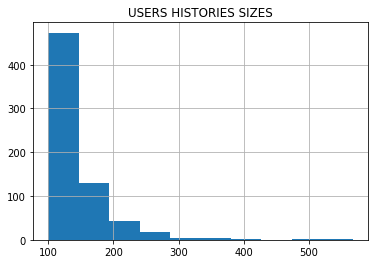

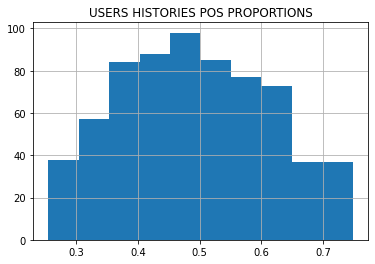

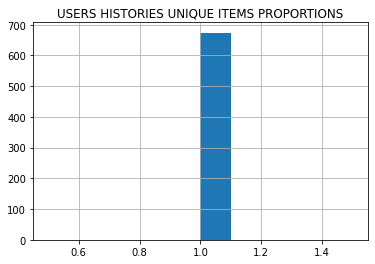

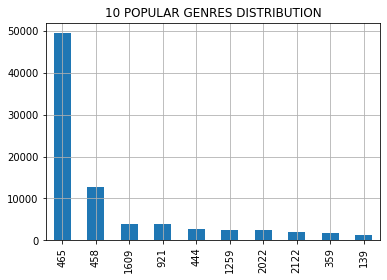

In [ ]:
plot_histories_stats(data_val, k=100, min_prop=MIN_PROP, max_prop=MAX_PROP, prepare=True)

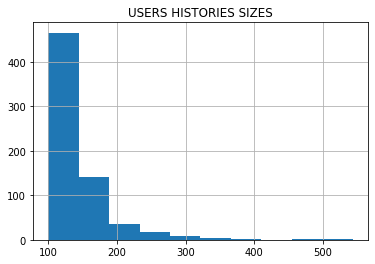

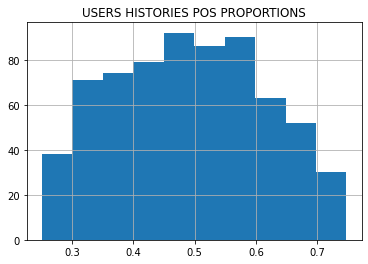

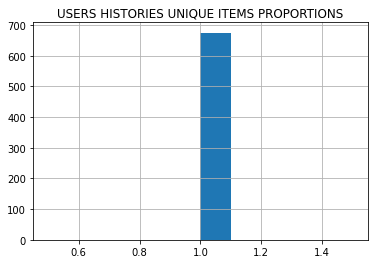

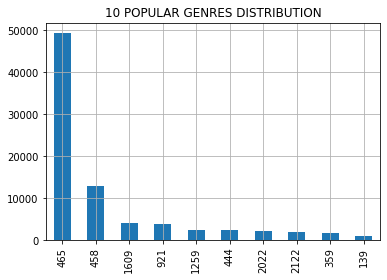

In [ ]:
plot_histories_stats(data_test, k=100, min_prop=MIN_PROP, max_prop=MAX_PROP, prepare=True)

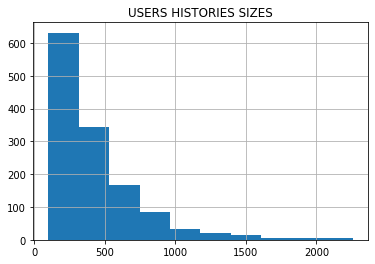

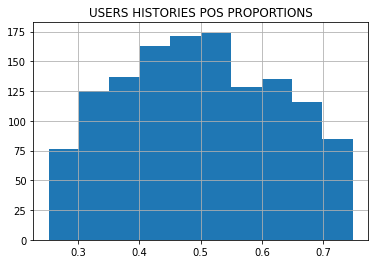

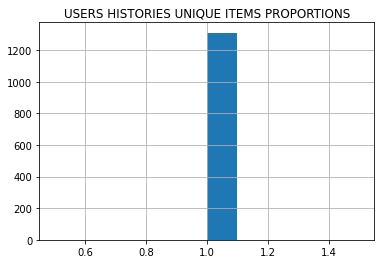

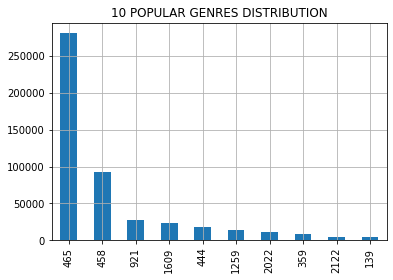

In [ ]:
plot_histories_stats(cold_users_data, k=100, min_prop=MIN_PROP, max_prop=MAX_PROP, prepare=True)

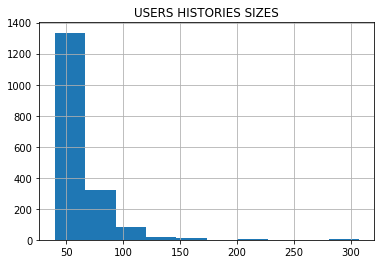

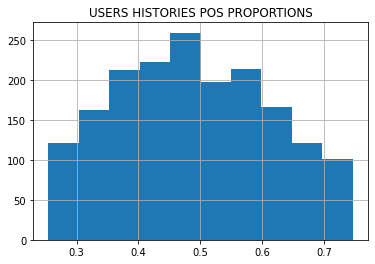

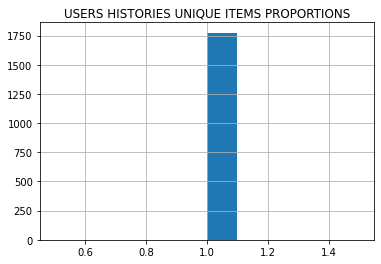

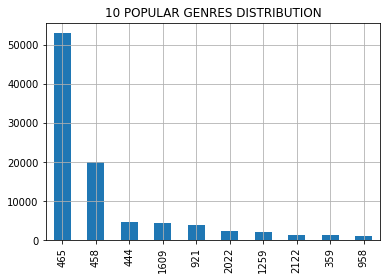

In [ ]:
plot_histories_stats(cold_items_data, k=40, min_prop=MIN_PROP, max_prop=MAX_PROP, prepare=True)

The stats and hists look similar, and we have unique items in histories.

### Random algorithm evaluation (do not use such a ranker in your tasks :)


In [ ]:
random_ranker = RandomRanker()

Validation data
----------
Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.6848017050539306
Users mean precision@5 on test: 0.4940652818991098


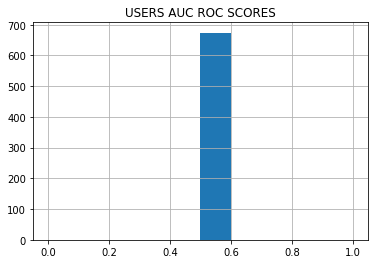

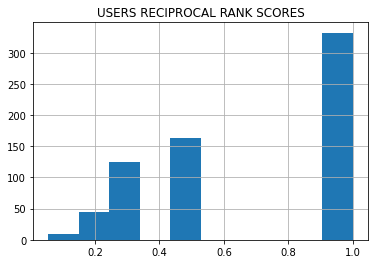

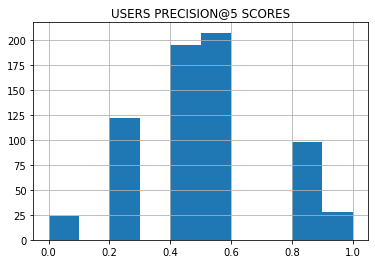

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Validation data")
print("----------")
val_real_pred = model_evaluation(random_ranker, data_val, 
                                 result_cols=result_cols, 
                                 user_id="msno", n=K,
                                 min_prop=MIN_PROP, max_prop=MAX_PROP)

In [ ]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,0
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,0
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,0
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,0
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,0


Train data
----------
Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.6846962285171566
Users mean precision@5 on test: 0.496351575456053


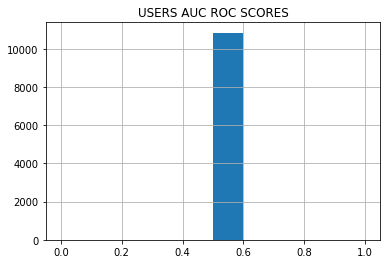

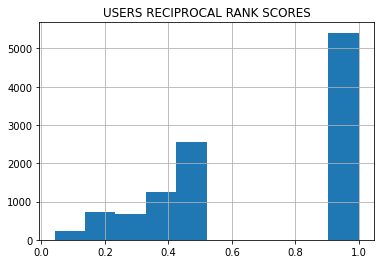

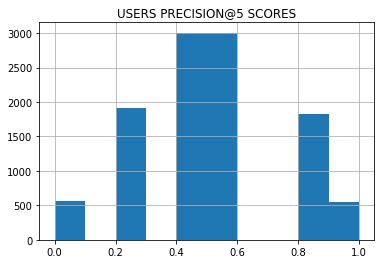

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Train data")
print("----------")
_ = model_evaluation(random_ranker, data_train_all, 
                    result_cols=result_cols, 
                    user_id="msno", n=K,
                    min_prop=MIN_PROP, max_prop=MAX_PROP)

Test data
----------
Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.6807817298577532
Users mean precision@5 on test: 0.4921481481481482


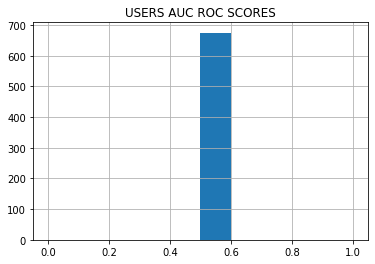

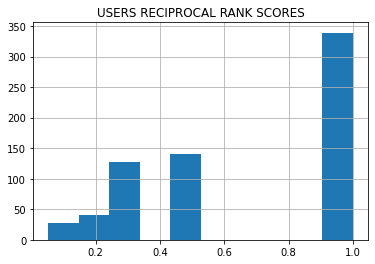

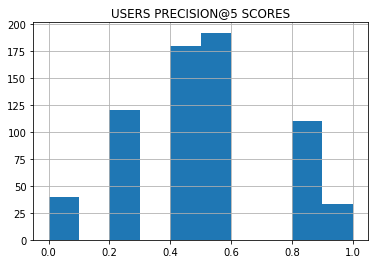

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Test data")
print("----------")
_ = model_evaluation(random_ranker, data_test, 
                      result_cols=result_cols, 
                      user_id="msno", n=K,
                      min_prop=MIN_PROP, max_prop=MAX_PROP)

Cold users data
----------
Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.6777837920075235
Users mean precision@5 on test: 0.49786259541984734


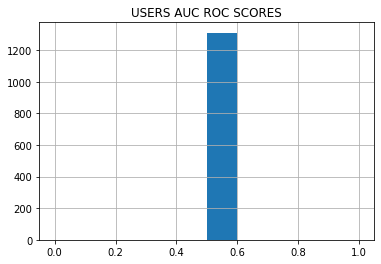

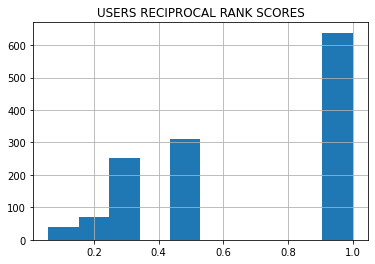

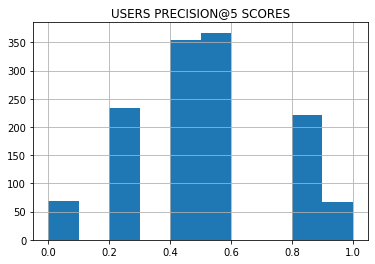

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Cold users data")
print("----------")
_ = model_evaluation(random_ranker, cold_users_data, 
                      result_cols=result_cols, 
                      user_id="msno", n=K,
                      min_prop=MIN_PROP, max_prop=MAX_PROP)

Cold items data
----------
Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.672866971838803
Users mean precision@5 on test: 0.48732394366197185


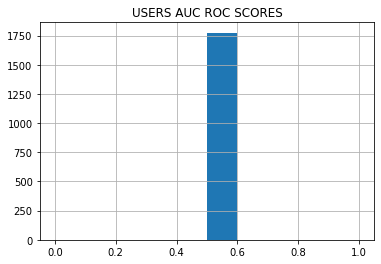

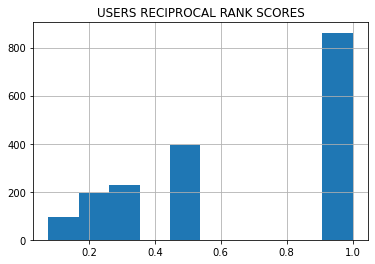

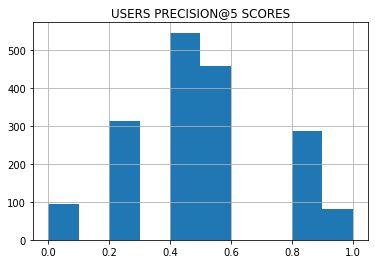

In [ ]:
#####
K = 40 #minimum size of user's history
#####
print("Cold items data")
print("----------")
_ = model_evaluation(random_ranker, cold_items_data, 
                      result_cols=result_cols, 
                      user_id="msno", n=K,
                      min_prop=MIN_PROP, max_prop=MAX_PROP)

### We can see that users' auc roc scores are 0.5 and precision scores are normally distributed in all the cases.

### Baseline ranker evaluation

In [ ]:
ranker = PopularRanker()
ranker.fit(data_train_pos)

PopularRanker()

Validation data
----------
Users mean AUC ROC on test: 0.6185951109612161
Users mean reciprocal rank on test: 0.9023791860958033
Users mean precision@5 on test: 0.7620178041543025


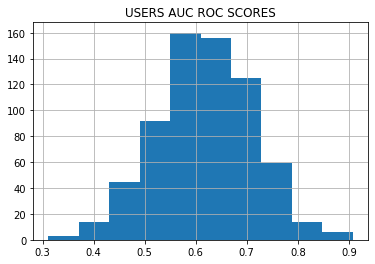

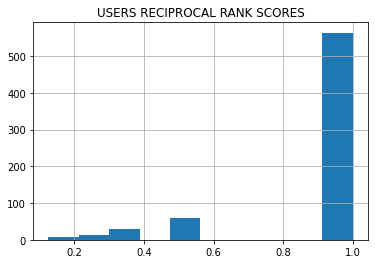

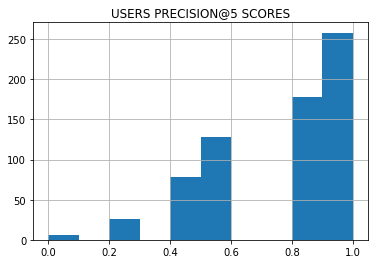

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Validation data")
print("----------")
val_real_pred = model_evaluation(ranker, data_val, 
                                 result_cols=result_cols, 
                                 user_id="msno", n=K,
                                 min_prop=MIN_PROP, max_prop=MAX_PROP)

In [ ]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,26.0
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,323.0
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,6.0
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,1116.0
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,1207.0


Train data
----------
Users mean AUC ROC on test: 0.6178626709311335
Users mean reciprocal rank on test: 0.872646962374072
Users mean precision@5 on test: 0.7580062649714392


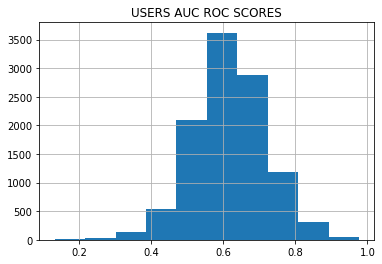

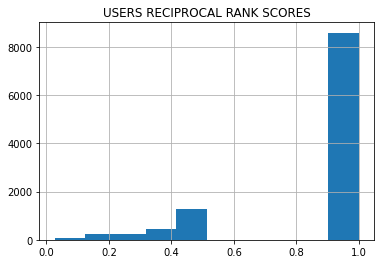

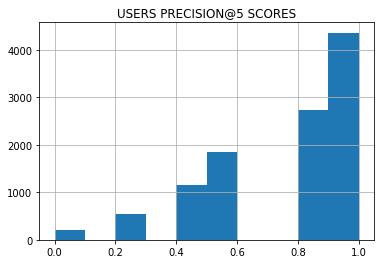

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Train data")
print("----------")
_ = model_evaluation(ranker, data_train_all, 
                    result_cols=result_cols, 
                    user_id="msno", n=K,
                    min_prop=MIN_PROP, max_prop=MAX_PROP)

Test data
----------
Users mean AUC ROC on test: 0.6204275176075262
Users mean reciprocal rank on test: 0.8871728395061729
Users mean precision@5 on test: 0.7768888888888891


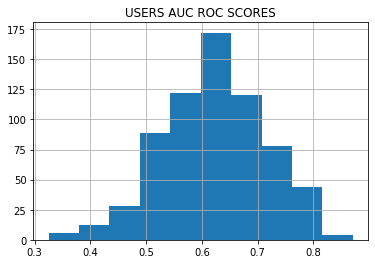

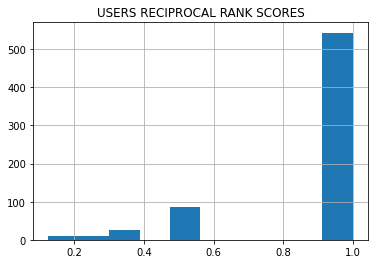

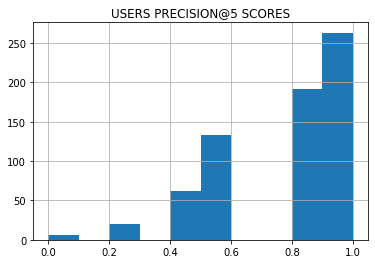

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Test data")
print("----------")
_ = model_evaluation(ranker, data_test, 
                      result_cols=result_cols, 
                      user_id="msno", n=K,
                      min_prop=MIN_PROP, max_prop=MAX_PROP)

Cold users data
----------
Users mean AUC ROC on test: 0.5950498330023948
Users mean reciprocal rank on test: 0.858361887576077
Users mean precision@5 on test: 0.747175572519084


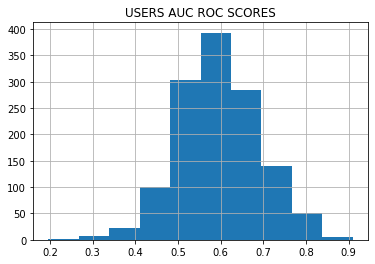

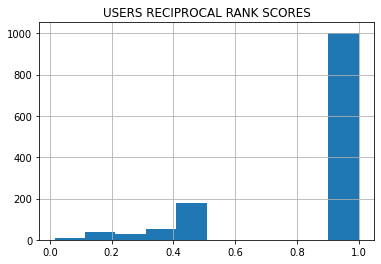

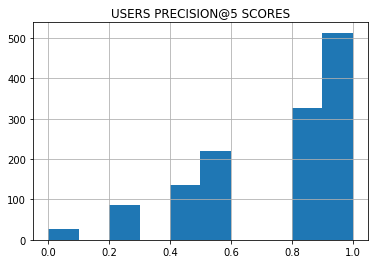

In [ ]:
#####
K = 100 #minimum size of user's history
#####
print("Cold users data")
print("----------")
_ = model_evaluation(ranker, cold_users_data, 
                      result_cols=result_cols, 
                      user_id="msno", n=K,
                      min_prop=MIN_PROP, max_prop=MAX_PROP)

Cold items data
----------
Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.672866971838803
Users mean precision@5 on test: 0.48732394366197185


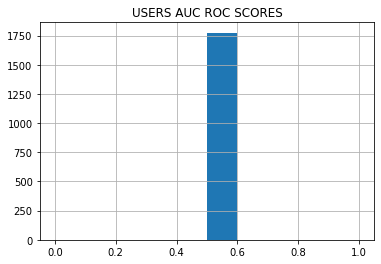

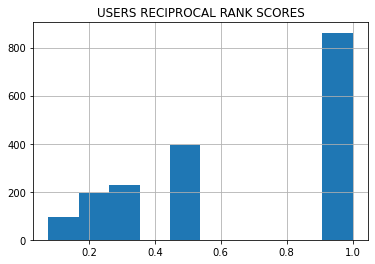

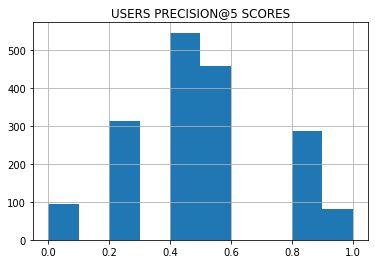

In [ ]:
#####
K = 40 #minimum size of user's history
#####
print("Cold items data")
print("----------")
_ = model_evaluation(ranker, cold_items_data, 
                      result_cols=result_cols, 
                      user_id="msno", n=K,
                      min_prop=MIN_PROP, max_prop=MAX_PROP)

### Here we can see better results  in all the cases but the last one - we don't have any info for cold items. This is our baseline solution. But can we do better? :)

### Stay tuned :)